# Making CMIP6 multimodel means

In [1]:
! pip install --upgrade cmip6_preprocessing
! pip install -e ../..

  Using cached cmip6_preprocessing-0.5.0-py3-none-any.whl (53 kB)
  Attempting uninstall: cmip6-preprocessing
    Found existing installation: cmip6-preprocessing 0.1.4
    Uninstalling cmip6-preprocessing-0.1.4:
      Successfully uninstalled cmip6-preprocessing-0.1.4
Obtaining file:///home/jovyan/seager19
  Running setup.py develop for src


### Get the CMIP6 catalogue

In [2]:
from intake import open_catalog

cat = open_catalog(
    "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml"
)["climate"]["cmip6_gcs"]

In [3]:
# import pprint
instit = cat.unique(["institution_id"])["institution_id"]["values"]
print(instit)

['NERC', 'NIMS-KMA', 'INM', 'CCCma', 'CAS', 'SNU', 'NCAR', 'MIROC', 'E3SM-Project', 'FIO-QLNM', 'CCCR-IITM', 'MPI-M', 'IPSL', 'THU', 'CSIRO', 'CNRM-CERFACS', 'UA', 'MOHC', 'CMCC', 'NUIST', 'AWI', 'NASA-GISS', 'DWD', 'KIOST', 'DKRZ', 'AS-RCEC', 'MRI', 'HAMMOZ-Consortium', 'NCC', 'CSIRO-ARCCSS', 'BCC', 'NOAA-GFDL', 'CAMS', 'EC-Earth-Consortium', 'RUBISCO', 'ECMWF']


In [21]:
source_l = cat.unique(["source_id"])["source_id"]["values"]

In [3]:
from typing import Union
import numpy as np
import pandas as pd
import xarray as xr
import dask
from cmip6_preprocessing.preprocessing import combined_preprocessing
import cftime
from intake import open_catalog

cat = open_catalog(
    "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml"
)["climate"]["cmip6_gcs"]
instit = cat.unique(["institution_id"])["institution_id"]["values"]

@np.vectorize
def standardise_time(time: Union[cftime._cftime.DatetimeNoLeap, cftime._cftime.Datetime360Day, np.datetime64]) -> cftime._cftime.Datetime360Day:
    if isinstance(time, np.datetime64):
        time = pd.to_datetime(time)
    # put the new time in the middle of the given month
    return cftime.datetime(time.year, time.month, 15, calendar="360_day")

def preproc(ds: xr.Dataset) -> xr.Dataset:
    ds = ds.copy()
    ds = combined_preprocessing(ds)
    # print(ds.time.values)
    ds = ds.assign_coords(time=standardise_time(ds.time.values))
    return ds

failed_list = []; empty_list = []; success_list = []; time_d = {}

for i in instit:
    print(i)
    query = dict(
        variable_id=["ts"],
        experiment_id=["historical"], # , "ssp585"],
        table_id=["Amon"],
        institution_id=[i],
    )
    subset = cat.search(**query)
    z_kwargs = {"consolidated": True, "decode_times": True}
    try:
        with dask.config.set(**{"array.slicing.split_large_chunks": True}):
            dset_dict_proc = subset.to_dataset_dict(zarr_kwargs=z_kwargs,
                                                    preprocess=preproc)

        # print(i, "suceeded")
        if len(dset_dict_proc) == 0:
            empty_list.append(i)

        else:
            success_list.append(i)
            for j in dset_dict_proc:
                time_d[i] = dset_dict_proc[j].time.values[0]

    except Exception as e:
        print(e)
        print(i, "failed")
        failed_list.append(i)

BCC

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


NCC

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:286: UserWarning: Found time as dimension in `lat_bounds`. Assuming this is an error and just picking the first step along that dimension.
  warnings.warn(


Failed to apply pre-processing function: preproc
NCC failed
ECMWF
MIROC


/srv/conda/envs/notebook/lib/python3.8/site-packages/intake_esm/search.py:107: UserWarning: Query returned zero results.
  warn(message)
/srv/conda/envs/notebook/lib/python3.8/site-packages/intake_esm/core.py:890: UserWarning: There are no datasets to load! Returning an empty dictionary.
  warn('There are no datasets to load! Returning an empty dictionary.')



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
Failed to apply pre-processing function: preproc
MIROC failed
IPSL

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
Failed to apply pre-processing function: preproc
IPSL failed
DWD
THU


/srv/conda/envs/notebook/lib/python3.8/site-packages/intake_esm/search.py:107: UserWarning: Query returned zero results.
  warn(message)
/srv/conda/envs/notebook/lib/python3.8/site-packages/intake_esm/core.py:890: UserWarning: There are no datasets to load! Returning an empty dictionary.
  warn('There are no datasets to load! Returning an empty dictionary.')



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


HAMMOZ-Consortium

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
Failed to apply pre-processing function: preproc
HAMMOZ-Consortium failed
CCCR-IITM

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


MPI-M

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
Failed to apply pre-processing function: preproc
MPI-M failed
AWI

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
Failed to apply pre-processing function: preproc
AWI failed
NIMS-KMA

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


MOHC

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


FIO-QLNM

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


CAMS

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


E3SM-Project

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


CAS

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")


NOAA-GFDL

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


KIOST

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


CNRM-CERFACS

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
Failed to apply pre-processing function: preproc
CNRM-CERFACS failed
RUBISCO
CMCC


/srv/conda/envs/notebook/lib/python3.8/site-packages/intake_esm/search.py:107: UserWarning: Query returned zero results.
  warn(message)
/srv/conda/envs/notebook/lib/python3.8/site-packages/intake_esm/core.py:890: UserWarning: There are no datasets to load! Returning an empty dictionary.
  warn('There are no datasets to load! Returning an empty dictionary.')



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


NERC
CSIRO


/srv/conda/envs/notebook/lib/python3.8/site-packages/intake_esm/search.py:107: UserWarning: Query returned zero results.
  warn(message)
/srv/conda/envs/notebook/lib/python3.8/site-packages/intake_esm/core.py:890: UserWarning: There are no datasets to load! Returning an empty dictionary.
  warn('There are no datasets to load! Returning an empty dictionary.')



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
Failed to apply pre-processing function: preproc
CSIRO failed
NUIST

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
Failed to apply pre-processing function: preproc
NUIST failed
SNU

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


UA

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


NCAR

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


NASA-GISS

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


CSIRO-ARCCSS

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
Failed to apply pre-processing function: preproc
CSIRO-ARCCSS failed
MRI

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
Failed to apply pre-processing function: preproc
MRI failed
DKRZ
EC-Earth-Consortium


/srv/conda/envs/notebook/lib/python3.8/site-packages/intake_esm/search.py:107: UserWarning: Query returned zero results.
  warn(message)
/srv/conda/envs/notebook/lib/python3.8/site-packages/intake_esm/core.py:890: UserWarning: There are no datasets to load! Returning an empty dictionary.
  warn('There are no datasets to load! Returning an empty dictionary.')



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
Failed to apply pre-processing function: preproc
EC-Earth-Consortium failed
CCCma

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


INM

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


AS-RCEC

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [6]:
success_list

['NCAR',
 'CAS',
 'NASA-GISS',
 'AS-RCEC',
 'E3SM-Project',
 'BCC',
 'CMCC',
 'INM',
 'NIMS-KMA',
 'CCCma',
 'CAMS',
 'CCCR-IITM',
 'MOHC',
 'NOAA-GFDL',
 'UA',
 'FIO-QLNM',
 'KIOST',
 'SNU',
 'THU']

In [12]:
import cftime

for i in sorted(time_d):
    print(i, "\t\t\t", type(time_d[i]), "\t\t\t", time_d[i])
    if isinstance(time_d[i], (cftime._cftime.DatetimeNoLeap, cftime._cftime.Datetime360Day)):
        print(time_d[i].year, time_d[i].month, time_d[i].day)
    elif isinstance(time_d[i], np.datetime64):
        x = pd.to_datetime(time_d["MRI"])
        print(x.year, x.month, x.day)

# "AWI", "MRI", "CSIRO-ARCCSS", "CCCma"

AS-RCEC 			 <class 'cftime._cftime.datetime'> 			 1850-01-15 00:00:00
BCC 			 <class 'cftime._cftime.datetime'> 			 1850-01-15 00:00:00
CAMS 			 <class 'cftime._cftime.datetime'> 			 1850-01-15 00:00:00
CAS 			 <class 'cftime._cftime.datetime'> 			 1850-01-15 00:00:00
CCCR-IITM 			 <class 'cftime._cftime.datetime'> 			 1850-01-15 00:00:00
CCCma 			 <class 'cftime._cftime.datetime'> 			 1850-01-15 00:00:00
CMCC 			 <class 'cftime._cftime.datetime'> 			 1850-01-15 00:00:00
E3SM-Project 			 <class 'cftime._cftime.datetime'> 			 1850-01-15 00:00:00
FIO-QLNM 			 <class 'cftime._cftime.datetime'> 			 1850-01-15 00:00:00
INM 			 <class 'cftime._cftime.datetime'> 			 1850-01-15 00:00:00
KIOST 			 <class 'cftime._cftime.datetime'> 			 1850-01-15 00:00:00
MOHC 			 <class 'cftime._cftime.datetime'> 			 1850-01-15 00:00:00
NASA-GISS 			 <class 'cftime._cftime.datetime'> 			 1850-01-15 00:00:00
NCAR 			 <class 'cftime._cftime.datetime'> 			 1850-01-15 00:00:00
NIMS-KMA 			 <class 'cftime._cftime.da

In [78]:
time_d["MRI"]

numpy.datetime64('1850-01-16T12:00:00.000000000')

In [75]:
import pandas as pd
x = pd.to_datetime(time_d["MRI"])

In [77]:
x.year

1850

In [66]:
import numpy as np
time_d["MRI"].astype(object)


-3785486400000000000

In [18]:
query = dict(
        variable_id=["ts"],
        experiment_id=["historical"],# , "ssp585"],
        table_id=["Amon"],
        # institution_id=["NCAR", "NOAA-GFDL", "MOHC", "NASA-GISS", "UA", "INM", "THU", "SNU", "E3SM-Project"],
    )
subset = cat.search(**query)

In [19]:
subset

,unique
activity_id,1
institution_id,31
source_id,62
experiment_id,1
member_id,152
table_id,1
variable_id,1
grid_label,3
zstore,554
dcpp_init_year,0


### Pick out the 60 years mean

In [7]:
import matplotlib.pyplot as plt
import xarray as xr
import dask
from cmip6_preprocessing.preprocessing import (
    rename_cmip6, 
    promote_empty_dims, 
    broadcast_lonlat, 
    replace_x_y_nominal_lat_lon,
    combined_preprocessing,
)


@np.vectorize
def standardise_time(time: Union[cftime._cftime.DatetimeNoLeap, cftime._cftime.Datetime360Day, np.datetime64]) -> cftime._cftime.Datetime360Day:
    if isinstance(time, np.datetime64):
        time = pd.to_datetime(time)
    # put the new time in the middle of the given month
    return cftime.datetime(time.year, time.month, 15, calendar="gregorian") # "360_day")

def preproc(ds: xr.Dataset) -> xr.Dataset:
    ds = ds.copy()
    ds = combined_preprocessing(ds)
    ds = ds.assign_coords(time=standardise_time(ds.time.values))
    return ds


def get_var(experiment="historical", year_begin="1958", year_end="2014", var="ts", xlim=[100, 290], ylim=[-30, 30]):
    query = dict(
        variable_id=[var],
        experiment_id=[experiment],# , "ssp585"],
        table_id=["Amon"],
        institution_id=[x for x in success_list if x not in ["AWI", "MRI", "CSIRO-ARCCSS", "CCCma"]],
    )
    subset = cat.search(**query)

    z_kwargs = {"consolidated": True, "decode_times": True}

    # pass the preprocessing directly
    with dask.config.set(**{"array.slicing.split_large_chunks": True}):
        dset_dict_proc = subset.to_dataset_dict(zarr_kwargs=z_kwargs,
                                                preprocess=preproc)
        
    da_list = []; key_list = []; first = True

    for key in dset_dict_proc:
        print(key)
        da = dset_dict_proc[key][var].sel(
            x=slice(xlim[0] - 1, xlim[1] + 1), 
            y=slice(ylim[0] - 1, ylim[1] + 1), 
            time=slice(year_begin, year_end)
        ).mean("member_id").interp(x=list(range(xlim[0], xlim[1] + 1)), 
                 y=list(range(ylim[0], ylim[1] + 1)))
        key_list.append(key)
        if first:
            times = da.time.values
        da = da.assign_coords(time=list(range(da.sizes["time"])))
        da_list.append(da)
    da = xr.concat(da_list, "model_center")
    da = da.assign_coords({"model_center": key_list, "time": times})
    
    return da

def get_mmm60(var="ts"):
    da_hist = get_var(xlim=[0, 360], ylim=[-80, 80], var=var)
    da_ssp585 = get_var(experiment="ssp585", year_begin="2014", year_end="2017", xlim=[0, 360], ylim=[-80, 80], var=var)
    da_comb = xr.concat([da_hist.mean("model_center"), da_ssp585.mean("model_center")], "time")
    da_comb.attrs["hist_list"] = str(da_hist["model_center"].values)
    da_comb.attrs["ssp585_list"] = str(da_ssp585["model_center"].values)
    return da_comb

In [8]:
clt_60 = get_mmm60("clt")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")


CMIP.NCAR.CESM2-WACCM.historical.Amon.gn
CMIP.INM.INM-CM4-8.historical.Amon.gr1
CMIP.E3SM-Project.E3SM-1-1.historical.Amon.gr
CMIP.CAS.FGOALS-g3.historical.Amon.gn
CMIP.CCCR-IITM.IITM-ESM.historical.Amon.gn
CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn
CMIP.AS-RCEC.TaiESM1.historical.Amon.gn
CMIP.CMCC.CMCC-ESM2.historical.Amon.gn
CMIP.CMCC.CMCC-CM2-HR4.historical.Amon.gn
CMIP.E3SM-Project.E3SM-1-1-ECA.historical.Amon.gr
CMIP.NCAR.CESM2-WACCM-FV2.historical.Amon.gn
CMIP.BCC.BCC-ESM1.historical.Amon.gn
CMIP.NCAR.CESM2-FV2.historical.Amon.gn
CMIP.MOHC.UKESM1-0-LL.historical.Amon.gn
CMIP.SNU.SAM0-UNICON.historical.Amon.gn
CMIP.NASA-GISS.GISS-E2-1-G-CC.historical.Amon.gn
CMIP.KIOST.KIOST-ESM.historical.Amon.gr1
CMIP.NASA-GISS.GISS-E2-1-H.historical.Amon.gn
CMIP.MOHC.HadGEM3-GC31-MM.historical.Amon.gn
CMIP.THU.CIESM.historical.Amon.gr
CMIP.CAS.FGOALS-f3-L.historical.Amon.gr
CMIP.E3SM-Project.E3SM-1-0.historical.Amon.gr
CMIP.CAS.CAS-ESM2-0.historical.Amon.gn
CMIP.CMCC.CMCC-CM2-SR5.historical.Amon.g

/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:286: UserWarning: Found time as dimension in `lat_bounds`. Assuming this is an error and just picking the first step along that dimension.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")


ScenarioMIP.NOAA-GFDL.GFDL-ESM4.ssp585.Amon.gr1
ScenarioMIP.THU.CIESM.ssp585.Amon.gr
ScenarioMIP.NIMS-KMA.KACE-1-0-G.ssp585.Amon.gr
ScenarioMIP.CAMS.CAMS-CSM1-0.ssp585.Amon.gn
ScenarioMIP.KIOST.KIOST-ESM.ssp585.Amon.gr1
ScenarioMIP.CCCR-IITM.IITM-ESM.ssp585.Amon.gn
ScenarioMIP.MOHC.HadGEM3-GC31-MM.ssp585.Amon.gn
ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp585.Amon.gn
ScenarioMIP.NCAR.CESM2.ssp585.Amon.gn
ScenarioMIP.CAS.FGOALS-g3.ssp585.Amon.gn
ScenarioMIP.MOHC.HadGEM3-GC31-LL.ssp585.Amon.gn
ScenarioMIP.NOAA-GFDL.GFDL-CM4.ssp585.Amon.gr1
ScenarioMIP.AS-RCEC.TaiESM1.ssp585.Amon.gn
ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn
ScenarioMIP.INM.INM-CM5-0.ssp585.Amon.gr1
ScenarioMIP.INM.INM-CM4-8.ssp585.Amon.gr1
ScenarioMIP.FIO-QLNM.FIO-ESM-2-0.ssp585.Amon.gn
ScenarioMIP.BCC.BCC-CSM2-MR.ssp585.Amon.gn
ScenarioMIP.CAS.CAS-ESM2-0.ssp585.Amon.gn
ScenarioMIP.E3SM-Project.E3SM-1-1.ssp585.Amon.gr
ScenarioMIP.CMCC.CMCC-ESM2.ssp585.Amon.gn
ScenarioMIP.CAS.FGOALS-f3-L.ssp585.Amon.gr
ScenarioMIP.NASA-GISS.GISS-E2

array([cftime.datetime(1958, 1, 15, 0, 0, 0, 0, calendar='gregorian'),
       cftime.datetime(1958, 2, 15, 0, 0, 0, 0, calendar='gregorian'),
       cftime.datetime(1958, 3, 15, 0, 0, 0, 0, calendar='gregorian'),
       cftime.datetime(1958, 4, 15, 0, 0, 0, 0, calendar='gregorian'),
       cftime.datetime(1958, 5, 15, 0, 0, 0, 0, calendar='gregorian'),
       cftime.datetime(1958, 6, 15, 0, 0, 0, 0, calendar='gregorian'),
       cftime.datetime(1958, 7, 15, 0, 0, 0, 0, calendar='gregorian'),
       cftime.datetime(1958, 8, 15, 0, 0, 0, 0, calendar='gregorian'),
       cftime.datetime(1958, 9, 15, 0, 0, 0, 0, calendar='gregorian'),
       cftime.datetime(1958, 10, 15, 0, 0, 0, 0, calendar='gregorian'),
       cftime.datetime(1958, 11, 15, 0, 0, 0, 0, calendar='gregorian'),
       cftime.datetime(1958, 12, 15, 0, 0, 0, 0, calendar='gregorian'),
       cftime.datetime(1959, 1, 15, 0, 0, 0, 0, calendar='gregorian'),
       cftime.datetime(1959, 2, 15, 0, 0, 0, 0, calendar='gregorian'),
   

In [26]:
clt_60

<xarray.DataArray 'clt' (time: 720, y: 161, x: 361)>
dask.array<concatenate, shape=(720, 161, 361), dtype=float32, chunksize=(63, 161, 361), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1958-01-15 00:00:00 ... 2017-12-15 00:00:00
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359 360
  * y        (y) int64 -80 -79 -78 -77 -76 -75 -74 -73 ... 74 75 76 77 78 79 80
Attributes:
    hist_list:    ['CMIP.SNU.SAM0-UNICON.historical.Amon.gn'\n 'CMIP.E3SM-Pro...
    ssp585_list:  ['ScenarioMIP.BCC.BCC-CSM2-MR.ssp585.Amon.gn'\n 'ScenarioMI...

In [ ]:
clt_60 = get_mmm60("clt")
ts_60 = get_mmm60("ts")
ps_60 = get_mmm60("ps")
pr_60 = get_mmm60("pr")
hur_60 = get_mmm60("hur")
hur_60 = hur_60.bfill("plev").isel(plev=0)

In [29]:
uas_60 = get_mmm60("uas")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")


CMIP.NOAA-GFDL.GFDL-CM4.historical.Amon.gr1
CMIP.THU.CIESM.historical.Amon.gr
CMIP.NIMS-KMA.UKESM1-0-LL.historical.Amon.gn
CMIP.NASA-GISS.GISS-E2-1-G-CC.historical.Amon.gn
CMIP.CMCC.CMCC-CM2-SR5.historical.Amon.gn
CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn
CMIP.BCC.BCC-ESM1.historical.Amon.gn
CMIP.MOHC.HadGEM3-GC31-MM.historical.Amon.gn
CMIP.NOAA-GFDL.GFDL-ESM4.historical.Amon.gr1
CMIP.MOHC.UKESM1-0-LL.historical.Amon.gn
CMIP.UA.MCM-UA-1-0.historical.Amon.gn
CMIP.NASA-GISS.GISS-E2-1-H.historical.Amon.gn
CMIP.INM.INM-CM4-8.historical.Amon.gr1
CMIP.CAS.CAS-ESM2-0.historical.Amon.gn
CMIP.CCCR-IITM.IITM-ESM.historical.Amon.gn
CMIP.CMCC.CMCC-ESM2.historical.Amon.gn
CMIP.CMCC.CMCC-CM2-HR4.historical.Amon.gn
CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn
CMIP.MOHC.HadGEM3-GC31-LL.historical.Amon.gn
CMIP.CAS.FGOALS-f3-L.historical.Amon.gr
CMIP.KIOST.KIOST-ESM.historical.Amon.gr1
CMIP.NIMS-KMA.KACE-1-0-G.historical.Amon.gr
CMIP.INM.INM-CM5-0.historical.Amon.gr1
CMIP.NASA-GISS.GISS-E2-1-G.historical.Amon

ValueError: 'height' not present in all datasets and coords='different'. Either add 'height' to datasets where it is missing or specify coords='minimal'.

In [ ]:
uas_60 = get_mmm60("vas")

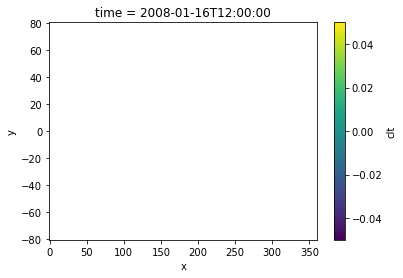

In [9]:
import xarray as xr
import os
da = xr.open_dataarray(os.path.join("nc", "clt" + "-CMIP6-clim60.nc"))
da.isel(time=600).plot()

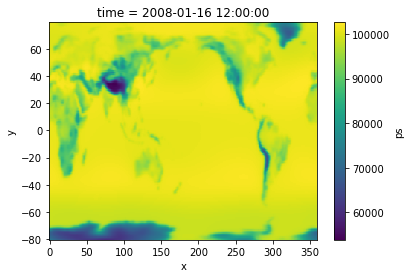

In [12]:
import xarray as xr
import os
da = xr.open_dataarray(os.path.join("nc", "ps" + "-CMIP6-clim60.nc"))
da.isel(time=600).plot()

In [ ]:
import os

def run_through() -> None:
    """Run through."""
    for i in ["clt", "ts", "ps", "pr"]: # ,# "hur"]:
        if i == "hur":
            mmm_60 = get_mmm60("hur").isel(plev=0).rename("rh") 
            # .isel(plev=slice(0, 3)).bfill("plev").isel(plev=0).rename("rh")
            mmm_60.to_netcdf(os.path.join("nc", "rh-CMIP6-clim60.nc"))
        else:
            mmm_60 = get_mmm60(i)
            mmm_60.to_netcdf(os.path.join("nc", i + "-CMIP6-clim60.nc"))

run_through()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4225: PerformanceWarning: Increasing number of chunks by factor of 16
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4225: PerformanceWarning: Increasing number of chunks by factor of 16
  result = bl

CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn
CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn
CMIP.BCC.BCC-ESM1.historical.Amon.gn
CMIP.EC-Earth-Consortium.EC-Earth3-CC.historical.Amon.gr
CMIP.CCCR-IITM.IITM-ESM.historical.Amon.gn
CMIP.NCAR.CESM2-WACCM-FV2.historical.Amon.gn
CMIP.MOHC.UKESM1-0-LL.historical.Amon.gn
CMIP.INM.INM-CM4-8.historical.Amon.gr1
CMIP.INM.INM-CM5-0.historical.Amon.gr1
CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Amon.gr
CMIP.NASA-GISS.GISS-E2-1-H.historical.Amon.gn
CMIP.NOAA-GFDL.GFDL-ESM4.historical.Amon.gr1
CMIP.CSIRO.ACCESS-ESM1-5.historical.Amon.gn
CMIP.THU.CIESM.historical.Amon.gr
CMIP.EC-Earth-Consortium.EC-Earth3-Veg-LR.historical.Amon.gr
CMIP.CAS.FGOALS-f3-L.historical.Amon.gr
CMIP.EC-Earth-Consortium.EC-Earth3-AerChem.historical.Amon.gr
CMIP.NASA-GISS.GISS-E2-1-G-CC.historical.Amon.gn
CMIP.FIO-QLNM.FIO-ESM-2-0.historical.Amon.gn
CMIP.CMCC.CMCC-CM2-HR4.historical.Amon.gn
CMIP.NUIST.NESM3.historical.Amon.gn
CMIP.NIMS-KMA.UKESM1-0-LL.historical.Amon.gn
CMIP.IPSL.IPSL-CM6A-

/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:286: UserWarning: Found time as dimension in `lat_bounds`. Assuming this is an error and just picking the first step along that dimension.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")


ScenarioMIP.CMCC.CMCC-ESM2.ssp585.Amon.gn
ScenarioMIP.BCC.BCC-CSM2-MR.ssp585.Amon.gn
ScenarioMIP.EC-Earth-Consortium.EC-Earth3-CC.ssp585.Amon.gr
ScenarioMIP.INM.INM-CM5-0.ssp585.Amon.gr1
ScenarioMIP.KIOST.KIOST-ESM.ssp585.Amon.gr1
ScenarioMIP.CNRM-CERFACS.CNRM-CM6-1-HR.ssp585.Amon.gr
ScenarioMIP.MPI-M.MPI-ESM1-2-LR.ssp585.Amon.gn
ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.Amon.gr
ScenarioMIP.NASA-GISS.GISS-E2-1-G.ssp585.Amon.gn
ScenarioMIP.CAMS.CAMS-CSM1-0.ssp585.Amon.gn
ScenarioMIP.E3SM-Project.E3SM-1-1.ssp585.Amon.gr
ScenarioMIP.CNRM-CERFACS.CNRM-ESM2-1.ssp585.Amon.gr
ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn
ScenarioMIP.NOAA-GFDL.GFDL-CM4.ssp585.Amon.gr1
ScenarioMIP.CNRM-CERFACS.CNRM-CM6-1.ssp585.Amon.gr
ScenarioMIP.NIMS-KMA.KACE-1-0-G.ssp585.Amon.gr
ScenarioMIP.NUIST.NESM3.ssp585.Amon.gn
ScenarioMIP.THU.CIESM.ssp585.Amon.gr
ScenarioMIP.CAS.CAS-ESM2-0.ssp585.Amon.gn
ScenarioMIP.CCCR-IITM.IITM-ESM.ssp585.Amon.gn
ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp585.Amon.gn
ScenarioMIP.FIO-QLNM.FIO-ESM-

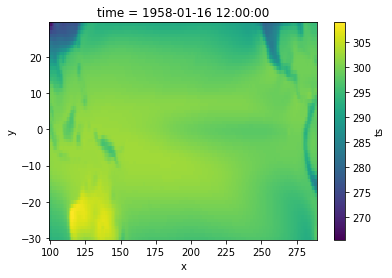

In [4]:
combined_da_60.isel(time=0).plot()

In [ ]:
[x for x in success_list if x not in ["AWI", "MRI", "CSIRO-ARCCSS", "CCCma"]]

In [6]:
combined_da_60.isel(time=0).to_netcdf("test1958.nc")

In [8]:
combined_da_60.mean("time").to_netcdf("ts-CMIP6-clim60.nc")

In [3]:
xr.open_dataarray("ts-CMIP6-clim60.nc")

<xarray.DataArray 'ts' (y: 160, x: 360)>
array([[231.15431, 231.98521, 231.63889, ..., 233.7208 , 233.34308, 233.98206],
       [231.52324, 231.9984 , 231.4507 , ..., 233.8675 , 233.49916, 234.05464],
       [231.68129, 231.96329, 231.2421 , ..., 233.8911 , 233.43497, 234.01778],
       ...,
       [269.8629 , 270.4461 , 270.65076, ..., 266.46286, 267.34332, 268.3447 ],
       [267.52377, 268.2427 , 268.60956, ..., 264.23926, 265.03806, 265.98547],
       [265.2135 , 265.3309 , 265.8335 , ..., 262.19775, 262.72098, 263.19543]],
      dtype=float32)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
  * y        (y) int64 -80 -79 -78 -77 -76 -75 -74 -73 ... 73 74 75 76 77 78 79

In [5]:
xr.open_dataarray("ts-CMIP6-clim60.nc").to_netcdf("ts-CMIP6-3-clim60.nc", format="NETCDF3_CLASSIC")

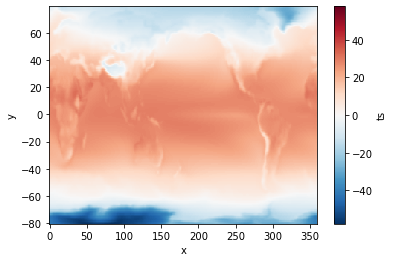

In [7]:
(xr.open_dataarray("ts-CMIP6-clim60.nc") - 273.15).plot()

In [2]:
from typing import Union
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import dask
from cmip6_preprocessing.preprocessing import (
    combined_preprocessing,
)
import cftime
from intake import open_catalog

cat = open_catalog(
    "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml"
)["climate"]["cmip6_gcs"]
instit = cat.unique(["institution_id"])["institution_id"]["values"]

@np.vectorize
def standardise_time(time: Union[cftime._cftime.DatetimeNoLeap, cftime._cftime.Datetime360Day, np.datetime64], 
                     calendar="standard", #"gregorian"
                    ) -> cftime._cftime.Datetime360Day:
    if isinstance(time, np.datetime64):
        time = pd.to_datetime(time)
    # put the new time in the middle of the given month
    # return np.datetime64(str(str(time.year) +  '-' + str(time.month) + '-' + str(15) + "T00:00:00"))
    return cftime.datetime(time.year, time.month, 15, calendar=calendar) # "360_day")

def preproc(ds: xr.Dataset) -> xr.Dataset:
    ds = ds.copy()
    ds = combined_preprocessing(ds)
    ds = ds.assign_coords(time=standardise_time(ds.time.values))
    return ds

def change_t_axis(ds: xr.Dataset, calendar="standard", #"gregorian"
                 ) -> xr.Dataset:
    # ds = change_t_axis(ds, calendar="360_day")
    ds = ds.copy()
    return  ds.assign_coords(time=standardise_time(ds.time.values), calendar=calendar)

def get_sucess_list():
    failed_list = []; empty_list = []; success_list = []; time_d = {}

    for i in instit:
        print(i)
        query = dict(
            variable_id=["ts"],
            experiment_id=["historical"], # , "ssp585"],
            table_id=["Amon"],
            institution_id=[i],
        )
        subset = cat.search(**query)
        z_kwargs = {"consolidated": True, "decode_times": True}
        try:
            with dask.config.set(**{"array.slicing.split_large_chunks": True}):
                dset_dict_proc = subset.to_dataset_dict(zarr_kwargs=z_kwargs,
                                                        preprocess=preproc)

            # print(i, "suceeded")
            if len(dset_dict_proc) == 0:
                empty_list.append(i)

            else:
                success_list.append(i)
                for j in dset_dict_proc:
                    time_d[i] = dset_dict_proc[j].time.values[0]

        except Exception as e:
            print(e)
            print(i, "failed")
            failed_list.append(i)

    return success_list

# success_list = get_sucess_list()
success_list = ['NCAR', 'CAMS', 'NOAA-GFDL', 'AS-RCEC', 'UA', 'FIO-QLNM', 'INM', 'CMCC', 'CAS',
                'CCCma', 'NIMS-KMA', 'NASA-GISS', 'E3SM-Project', 'MOHC', 'KIOST', 'BCC',
                'SNU', 'CCCR-IITM', 'THU']

print("success list ", success_list)

def get_ts(experiment="historical", year_begin="1958", year_end="2014", var="ts", xlim=[100, 290], ylim=[-30, 30]):
    query = dict(
        variable_id=[var],
        experiment_id=[experiment],# , "ssp585"],
        table_id=["Amon"],
        institution_id=[x for x in success_list if x not in ["AWI", "MRI", "CSIRO-ARCCSS", "CCCma"]],
    )
    subset = cat.search(**query)

    z_kwargs = {"consolidated": True, "decode_times": True}

    # pass the preprocessing directly
    with dask.config.set(**{"array.slicing.split_large_chunks": True}):
        dset_dict_proc = subset.to_dataset_dict(zarr_kwargs=z_kwargs,
                                                preprocess=preproc)
        
    da_list = []; key_list = []; first = True

    for key in dset_dict_proc:
        print(key)
        da = dset_dict_proc[key][var].sel(
            x=slice(xlim[0] - 1, xlim[1] + 1), 
            y=slice(ylim[0] - 1, ylim[1] + 1), 
            time=slice(year_begin, year_end)
        ).interp(x=list(range(xlim[0], xlim[1] + 1)), 
                 y=list(range(ylim[0], ylim[1] + 1)))
        
        for i in da.member_id.values:
            key_list.append(key + "." + i)
            sub_da = da.sel(member_id=i)
            key_split = key.split(".")
            sub_da = sub_da.assign_coords({"institution": key_split[1], "model": key_split[2]})
            da_list.append(sub_da)
    da = xr.concat(da_list, "member")
    da = da.assign_coords({"member": key_list}) # , "time": times})
    
    return da

def get_ensemble(var="ts"):
    da_hist = get_ts(xlim=[0, 360], ylim=[-80, 80], var=var)
    da_ssp585 = get_ts(experiment="ssp585", year_begin="2014", year_end="2017", xlim=[0, 360], ylim=[-80, 80], var=var)
    da_comb = xr.concat([da_hist.mean("model_center"), da_ssp585.mean("model_center")], "time")
    da_comb.attrs["hist_list"] = str(da_hist["model_center"].values)
    da_comb.attrs["ssp585_list"] = str(da_ssp585["model_center"].values)
    return da_comb

da_hist = get_ts(xlim=[0, 360], ylim=[-80, 80], var="ts")
da_ssp585 = get_ts(experiment="ssp585", year_begin="2014", year_end="2017", xlim=[0, 360], ylim=[-80, 80], var="ts")

success list  ['NCAR', 'CAMS', 'NOAA-GFDL', 'AS-RCEC', 'UA', 'FIO-QLNM', 'INM', 'CMCC', 'CAS', 'CCCma', 'NIMS-KMA', 'NASA-GISS', 'E3SM-Project', 'MOHC', 'KIOST', 'BCC', 'SNU', 'CCCR-IITM', 'THU']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")


CMIP.NIMS-KMA.UKESM1-0-LL.historical.Amon.gn
CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn
CMIP.THU.CIESM.historical.Amon.gr
CMIP.NCAR.CESM2-WACCM.historical.Amon.gn
CMIP.CCCR-IITM.IITM-ESM.historical.Amon.gn
CMIP.INM.INM-CM4-8.historical.Amon.gr1
CMIP.E3SM-Project.E3SM-1-0.historical.Amon.gr
CMIP.E3SM-Project.E3SM-1-1.historical.Amon.gr
CMIP.NCAR.CESM2-FV2.historical.Amon.gn
CMIP.CMCC.CMCC-CM2-SR5.historical.Amon.gn
CMIP.CAS.FGOALS-f3-L.historical.Amon.gr
CMIP.NCAR.CESM2-WACCM-FV2.historical.Amon.gn
CMIP.MOHC.HadGEM3-GC31-LL.historical.Amon.gn
CMIP.MOHC.HadGEM3-GC31-MM.historical.Amon.gn
CMIP.BCC.BCC-ESM1.historical.Amon.gn
CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn
CMIP.UA.MCM-UA-1-0.historical.Amon.gn
CMIP.NCAR.CESM2.historical.Amon.gn
CMIP.SNU.SAM0-UNICON.historical.Amon.gn
CMIP.E3SM-Project.E3SM-1-1-ECA.historical.Amon.gr
CMIP.AS-RCEC.TaiESM1.historical.Amon.gn
CMIP.INM.INM-CM5-0.historical.Amon.gr1
CMIP.NOAA-GFDL.GFDL-CM4.historical.Amon.gr1
CMIP.NOAA-GFDL.GFDL-ESM4.historical.Amon.gr1
C

/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")


ScenarioMIP.UA.MCM-UA-1-0.ssp585.Amon.gn
ScenarioMIP.E3SM-Project.E3SM-1-1.ssp585.Amon.gr
ScenarioMIP.INM.INM-CM4-8.ssp585.Amon.gr1
ScenarioMIP.MOHC.HadGEM3-GC31-MM.ssp585.Amon.gn
ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn
ScenarioMIP.CAS.CAS-ESM2-0.ssp585.Amon.gn
ScenarioMIP.INM.INM-CM5-0.ssp585.Amon.gr1
ScenarioMIP.MOHC.HadGEM3-GC31-LL.ssp585.Amon.gn
ScenarioMIP.CMCC.CMCC-ESM2.ssp585.Amon.gn
ScenarioMIP.THU.CIESM.ssp585.Amon.gr
ScenarioMIP.NIMS-KMA.KACE-1-0-G.ssp585.Amon.gr
ScenarioMIP.MOHC.UKESM1-0-LL.ssp585.Amon.gn
ScenarioMIP.CAMS.CAMS-CSM1-0.ssp585.Amon.gn
ScenarioMIP.AS-RCEC.TaiESM1.ssp585.Amon.gn
ScenarioMIP.BCC.BCC-CSM2-MR.ssp585.Amon.gn
ScenarioMIP.KIOST.KIOST-ESM.ssp585.Amon.gr1
ScenarioMIP.CAS.FGOALS-f3-L.ssp585.Amon.gr
ScenarioMIP.CCCR-IITM.IITM-ESM.ssp585.Amon.gn
ScenarioMIP.NOAA-GFDL.GFDL-ESM4.ssp585.Amon.gr1
ScenarioMIP.NCAR.CESM2.ssp585.Amon.gn
ScenarioMIP.FIO-QLNM.FIO-ESM-2-0.ssp585.Amon.gn
ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp585.Amon.gn
ScenarioMIP.CAS.FGOALS-g3.ssp585

In [ ]:
def comp_and_match(instit="NCAR"):
    ssp585_instit = da_ssp585.where(da_ssp585.institution == instit, drop=True)
    hist_instit = da_hist.where(da_hist.institution == instit, drop=True)
    #print(ssp585_instit.member.values)
    #print(hist_instit.member.values)
    da_list = []; key_list = []
    for model in ssp585_instit.model.values:
        ssp585_model = ssp585_instit.where(ssp585_instit.model == model, drop=True)
        hist_model = hist_instit.where(hist_instit.model == model, drop=True)        
        #print(ssp585_model.member.values)
        #print(hist_model.member.values)
        for member_id in ssp585_instit.member_id.values:
            ssp585_member = ssp585_model.where(ssp585_model.member_id == member_id, drop=True)
            hist_member = hist_model.where(hist_model.member_id == member_id, drop=True)
            if len(ssp585_member.member.values) != 0 and len(hist_member.member.values) != 0:
                print(hist_member.member.values)
                print(ssp585_member.member.values)
                # if len(ssp585_member.member.values) !=0 and  len(hist_member.member.values) != 0:
                # if len(da_list) <= 1:
                ensemble_da = xr.concat([hist_member.isel(member=0).drop("member"), ssp585_member.isel(member=0).drop("member")], "time")
                    # da_list.append(ensemble_da)
                    # key_list.append(ssp585_member.member.values[0])
                ensemble_da.to_netcdf( "nc/ts." + str(instit) + "." + str(model) + "."+  str(member_id) + ".60.nc")
            else:
                print("problem with " + model +" "+ member_id)
    # da = xr.concat(da_list, "member")
    # da = da.assign_coords({"member": key_list}) 
    # return da_list

# da_list = 
for instit in success_list:
    comp_and_match(instit=instit)
#comp_and_match(instit="NCAR")
# print(da_list)

problem with CESM2-WACCM r5i1p1f1
problem with CESM2-WACCM r4i1p1f1
['CMIP.NCAR.CESM2-WACCM.historical.Amon.gn.r2i1p1f1']
['ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn.r2i1p1f1']


In [29]:
rm nc/*

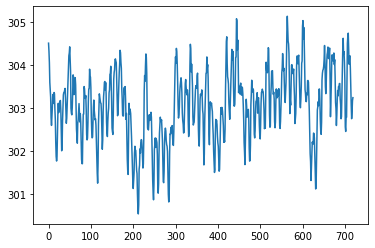

In [28]:
plt.plot(xr.open_dataarray("nc/ts.NCAR.CESM2-WACCM.r2i1p1f1.60.nc").isel(member=0, x=200, y=70).values)

In [82]:
da = xr.concat([da_hist.sel(member="CMIP.NCAR.CESM2.historical.Amon.gn.r10i1p1f1"), 
                da_ssp585.sel(member="ScenarioMIP.NCAR.CESM2.ssp585.Amon.gn.r10i1p1f1")], 
               "time")
print(da.isel(y=0, x=0).values)

[250.13622538 245.1396798  232.56019677 226.9844479  226.48700884
 228.23251088 222.9032152  226.21772681 226.3467865  229.51498498
 241.29542881 250.5674057  252.64657593 244.69809723 236.38956536
 227.11566586 222.94044071 220.20376417 226.11002858 227.16304101
 224.52687836 228.14383104 244.13165453 251.28262329 253.79222361
 245.63952043 232.44309998 229.90730709 223.99898444 226.29912313
 223.47932519 220.04975637 224.39664629 233.75992754 241.2973014
 252.54993439 251.13229116 240.50979614 234.90376197 226.52209049
 228.56201765 222.09093051 226.55942112 218.87322405 223.35430484
 230.4243927  242.48228539 252.21551344 251.28615485 243.25046624
 236.64879015 227.56303236 225.83847809 223.38235135 221.9819692
 223.13170539 220.97834947 233.85028161 241.22594367 253.10712263
 254.00882636 243.9666392  230.55327521 230.73187849 228.36325667
 221.27001784 224.23412747 221.31969537 222.46764543 226.81484646
 239.10111576 251.23127238 251.05103048 239.67749023 231.27133942
 226.3267737

In [6]:
len(da_list)

6

In [86]:
da

<xarray.DataArray 'ts' (time: 720, y: 161, x: 361)>
dask.array<concatenate, shape=(720, 161, 361), dtype=float32, chunksize=(92, 161, 361), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) object 1958-01-15 00:00:00 ... 2017-12-15 00:00:00
    lon          (x, y) float64 360.0 360.0 360.0 360.0 ... nan nan nan nan
    lat          (x, y) float64 -80.0 -79.0 -78.0 -77.0 ... nan nan nan nan
    member_id    <U10 'r10i1p1f1'
  * x            (x) int64 0 1 2 3 4 5 6 7 8 ... 353 354 355 356 357 358 359 360
  * y            (y) int64 -80 -79 -78 -77 -76 -75 -74 ... 74 75 76 77 78 79 80
    institution  <U12 'NCAR'
    model        <U15 'CESM2'
    member       (time) <U58 'CMIP.NCAR.CESM2.historical.Amon.gn.r10i1p1f1' ....
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean (interval: 1 month)
    comment:        Temperature of the lower boundary of the atmosphere
    long_name:      Surface Temperature
    original_name:  ts
    standard_name:  surface_temperature
    units:          K

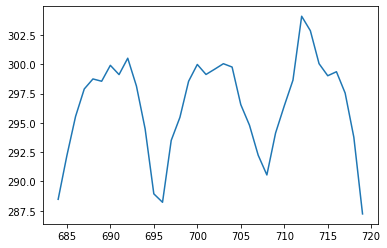

In [68]:
plt.plot(da_list[0].isel(x=100, y=100, member=0).values) # .plot()

In [71]:
da = change_t_axis(da_list[0].isel(x=100, y=100, member=0), calendar="standard")

TypeError: float() argument must be a string or a number, not 'cftime._cftime.datetime'

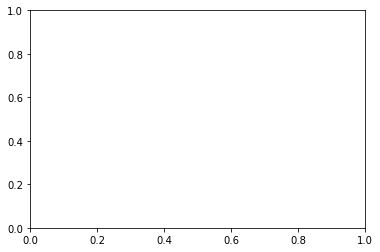

In [72]:
da.plot()

In [63]:
da_list[0].isel(x=50, y=50, member=0)

<xarray.DataArray 'ts' (time: 720)>
dask.array<getitem, shape=(720,), dtype=float64, chunksize=(228,), chunktype=numpy.ndarray>
Coordinates:
    member       <U52 'ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn.r5i1p1f1'
  * time         (time) object 2015-01-15 00:00:00 ... 2014-12-15 00:00:00
    lon          (time) float64 50.0 50.0 50.0 50.0 50.0 ... nan nan nan nan nan
    lat          (time) float64 -30.0 -30.0 -30.0 -30.0 ... nan nan nan nan
    member_id    (time) object 'r5i1p1f1' 'r5i1p1f1' 'r5i1p1f1' ... nan nan nan
    x            int64 50
    y            int64 -30
    institution  (time) object 'NCAR' 'NCAR' 'NCAR' 'NCAR' ... nan nan nan nan
    model        (time) object 'CESM2-WACCM' 'CESM2-WACCM' ... nan nan
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        Temperature of the lower boundary of the atmosphere
    long_name:      Surface Temperature
    original_name:  TS
    standard_name:  surface_temperature
    units:          K

In [55]:
def change_t_axis(ds: xr.Dataset, calendar="gregorian") -> xr.Dataset:
    # ds = change_t_axis(ds, calendar="360_day")
    ds = ds.copy()
    return  ds.assign_coords(time=standardise_time(ds.time.values, calendar=calendar))

In [73]:
print(da_list[0].isel(x=100, y=100, member=0).values)

[         nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          

In [35]:
! pip install --upgrade xarray
! pip install --upgrade nc-time-axis
! pip install --upgrade numpy

  Using cached xarray-0.18.2-py3-none-any.whl (807 kB)
  Using cached xarray-0.18.1-py3-none-any.whl (807 kB)
  Using cached nc_time_axis-1.3.1-py3-none-any.whl (12 kB)
  Using cached nc_time_axis-1.3.0-py3-none-any.whl (12 kB)
  Using cached numpy-1.21.0-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.0
    Uninstalling numpy-1.20.0:
      Successfully uninstalled numpy-1.20.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymbolic 2020.1 requires pytest>=2.3, which is not installed.
ciso 0.1.0 requires cython, which is not installed.


In [51]:
da_ssp585.sizes['member']

55

In [56]:
da_ssp585.where(da_ssp585.institution == "NCAR", drop=True)

<xarray.DataArray 'ts' (member: 8, time: 36, y: 161, x: 361)>
dask.array<where, shape=(8, 36, 161, 361), dtype=float32, chunksize=(1, 36, 161, 361), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) object 2015-01-15 00:00:00 ... 2017-12-15 00:00:00
    lon          (member, x, y) float64 360.0 360.0 360.0 360.0 ... nan nan nan
    lat          (member, x, y) float64 -80.0 -79.0 -78.0 -77.0 ... nan nan nan
    member_id    (member) <U9 'r11i1p1f1' 'r10i1p1f1' ... 'r2i1p1f1' 'r1i1p1f1'
  * x            (x) int64 0 1 2 3 4 5 6 7 8 ... 353 354 355 356 357 358 359 360
  * y            (y) int64 -80 -79 -78 -77 -76 -75 -74 ... 74 75 76 77 78 79 80
    institution  (member) <U12 'NCAR' 'NCAR' 'NCAR' ... 'NCAR' 'NCAR' 'NCAR'
    model        (member) <U15 'CESM2' 'CESM2' ... 'CESM2-WACCM' 'CESM2-WACCM'
  * member       (member) <U57 'ScenarioMIP.NCAR.CESM2.ssp585.Amon.gn.r11i1p1...
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        Temperature of the lower boundary of the atmosphere
    history:        2020-05-11T06:20:11Z altered by CMOR: Converted type from...
    long_name:      Surface Temperature
    original_name:  TS
    standard_name:  surface_temperature
    units:          K

In [ ]:
def comp_and_match(instit="NCAR"):
    ssp585_instit = da_ssp585.where(da_ssp585.institution == instit, drop=True)
    hist_instit = da_hist.where(da_hist.institution == instit, drop=True)
    print(ssp585_instit.member.values)
    print(hist_instit.member.values)
    da_list = []; key_list = []
    for model in ssp585_instit.model.values:
        ssp585_model = ssp585_instit.where(ssp585_instit.model == model, drop=True)
        hist_model = hist_instit.where(hist_instit.model == model, drop=True)        
        #print(ssp585_model.member.values)
        #print(hist_model.member.values)
        for member_id in ssp585_instit.member_id.values:
            ssp585_member = ssp585_model.where(ssp585_model.member_id == member_id, drop=True)
            hist_member = hist_model.where(hist_model.member_id == member_id, drop=True)
            if len(ssp585_member.member.values) != 0:
                print(ssp585_member.member.values)
                print(hist_member.member.values)
                da_list.append(xr.concat([ssp585_member, hist_member], "time"))
                key_list.append(ssp585_member.member.values[0])
            else:
                print("problem with " + model +" "+ member_id)
    da = xr.concat(da_list, "member")
    da = da.assign_coords({"member": key_list}) 
    return da

comp_and_match(instit="NCAR")

['ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn.r5i1p1f1'
 'ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn.r4i1p1f1'
 'ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn.r3i1p1f1'
 'ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn.r2i1p1f1'
 'ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn.r1i1p1f1'
 'ScenarioMIP.NCAR.CESM2.ssp585.Amon.gn.r11i1p1f1'
 'ScenarioMIP.NCAR.CESM2.ssp585.Amon.gn.r10i1p1f1'
 'ScenarioMIP.NCAR.CESM2.ssp585.Amon.gn.r4i1p1f1']
['CMIP.NCAR.CESM2-FV2.historical.Amon.gn.r1i1p1f1'
 'CMIP.NCAR.CESM2-FV2.historical.Amon.gn.r2i1p1f1'
 'CMIP.NCAR.CESM2-FV2.historical.Amon.gn.r3i1p1f1'
 'CMIP.NCAR.CESM2.historical.Amon.gn.r5i1p1f1'
 'CMIP.NCAR.CESM2.historical.Amon.gn.r4i1p1f1'
 'CMIP.NCAR.CESM2.historical.Amon.gn.r3i1p1f1'
 'CMIP.NCAR.CESM2.historical.Amon.gn.r2i1p1f1'
 'CMIP.NCAR.CESM2.historical.Amon.gn.r1i1p1f1'
 'CMIP.NCAR.CESM2.historical.Amon.gn.r6i1p1f1'
 'CMIP.NCAR.CESM2.historical.Amon.gn.r7i1p1f1'
 'CMIP.NCAR.CESM2.historical.Amon.gn.r8i1p1f1'
 'CMIP.NCAR.CESM2.historical.Amon.gn.r

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:248: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  flag_array = (arr1 == arr2) | (isnull(arr1) & isnull(arr2))
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:248: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  flag_array = (arr1 == arr2) | (isnull(arr1) & isnull(arr2))
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:248: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  flag_array = (arr1 == arr2) | (isnull(arr1) & isnull(arr2))


['ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn.r4i1p1f1']
[]


/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:248: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  flag_array = (arr1 == arr2) | (isnull(arr1) & isnull(arr2))
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:248: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  flag_array = (arr1 == arr2) | (isnull(arr1) & isnull(arr2))
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:248: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  flag_array = (arr1 == arr2) | (isnull(arr1) & isnull(arr2))


['ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn.r3i1p1f1']
['CMIP.NCAR.CESM2-WACCM.historical.Amon.gn.r3i1p1f1']
['ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn.r2i1p1f1']
['CMIP.NCAR.CESM2-WACCM.historical.Amon.gn.r2i1p1f1']
['ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn.r1i1p1f1']
['CMIP.NCAR.CESM2-WACCM.historical.Amon.gn.r1i1p1f1']
problem with CESM2-WACCM r11i1p1f1
problem with CESM2-WACCM r10i1p1f1
['ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn.r4i1p1f1']
[]


/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:248: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  flag_array = (arr1 == arr2) | (isnull(arr1) & isnull(arr2))
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:248: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  flag_array = (arr1 == arr2) | (isnull(arr1) & isnull(arr2))
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:248: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  flag_array = (arr1 == arr2) | (isnull(arr1) & isnull(arr2))


['ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn.r5i1p1f1']
[]


/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:248: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  flag_array = (arr1 == arr2) | (isnull(arr1) & isnull(arr2))
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:248: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  flag_array = (arr1 == arr2) | (isnull(arr1) & isnull(arr2))
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:248: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  flag_array = (arr1 == arr2) | (isnull(arr1) & isnull(arr2))


['ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn.r4i1p1f1']
[]


/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:248: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  flag_array = (arr1 == arr2) | (isnull(arr1) & isnull(arr2))
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:248: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  flag_array = (arr1 == arr2) | (isnull(arr1) & isnull(arr2))
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:248: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  flag_array = (arr1 == arr2) | (isnull(arr1) & isnull(arr2))


['ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn.r3i1p1f1']
['CMIP.NCAR.CESM2-WACCM.historical.Amon.gn.r3i1p1f1']
['ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn.r2i1p1f1']
['CMIP.NCAR.CESM2-WACCM.historical.Amon.gn.r2i1p1f1']
['ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn.r1i1p1f1']
['CMIP.NCAR.CESM2-WACCM.historical.Amon.gn.r1i1p1f1']
problem with CESM2-WACCM r11i1p1f1
problem with CESM2-WACCM r10i1p1f1
['ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn.r4i1p1f1']
[]


/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:248: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  flag_array = (arr1 == arr2) | (isnull(arr1) & isnull(arr2))
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:248: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  flag_array = (arr1 == arr2) | (isnull(arr1) & isnull(arr2))
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:248: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  flag_array = (arr1 == arr2) | (isnull(arr1) & isnull(arr2))


['ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn.r5i1p1f1']
[]


/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:248: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  flag_array = (arr1 == arr2) | (isnull(arr1) & isnull(arr2))
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:248: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  flag_array = (arr1 == arr2) | (isnull(arr1) & isnull(arr2))
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:248: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  flag_array = (arr1 == arr2) | (isnull(arr1) & isnull(arr2))


['ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn.r4i1p1f1']
[]


/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:248: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  flag_array = (arr1 == arr2) | (isnull(arr1) & isnull(arr2))
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:248: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  flag_array = (arr1 == arr2) | (isnull(arr1) & isnull(arr2))
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/duck_array_ops.py:248: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  flag_array = (arr1 == arr2) | (isnull(arr1) & isnull(arr2))


['ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn.r3i1p1f1']
['CMIP.NCAR.CESM2-WACCM.historical.Amon.gn.r3i1p1f1']
['ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn.r2i1p1f1']
['CMIP.NCAR.CESM2-WACCM.historical.Amon.gn.r2i1p1f1']


cmip6_mmm.ipynb  intake_cmip6.ipynb  nc/
